In [1]:
!pip install --upgrade scipy

In [12]:
pip install "numpy>=1.16.5,<1.23.0"

Note: you may need to restart the kernel to use updated packages.


In [1]:
import warnings
import os
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import tensorflow as tf
import shutil
import matplotlib.patches as mpatches


from shutil import copyfile

from tensorflow import keras
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras import layers, Input
from keras.layers import InputLayer, MaxPooling2D, Flatten, Dense, Conv2D, Dropout
from keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from sklearn import metrics
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL.Image import open
from PIL import Image

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Cargamos el dataset

data_raw = pd.read_csv("/kaggle/input/brain-tumor/Brain Tumor.csv")[['Image', 'Class']]
display(data_raw.head())
print(data_raw.shape)

,Image,Class
0,Image1,0
1,Image2,0
2,Image3,1
3,Image4,1
4,Image5,0


(3762, 2)


In [3]:
# Añadir a un dataframe el nombre de la imagen, su clase y el path en los directorios

data = pd.DataFrame()
data["Image"] = data_raw["Image"]
data["Class"] = data_raw["Class"]

path_list = []
for img_path in os.listdir('/kaggle/input/brain-tumor/Brain Tumor/Brain Tumor'):
    path_list.append( os.path.join('/kaggle/input/brain-tumor/Brain Tumor/Brain Tumor',img_path))
path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in path_list}
data["paths"] = data_raw["Image"].map(path_dict.get)

In [4]:
# Se definen las dimensiones de las imágenes

IMG_HEIGHT = 224
IMG_WIDTH = 224

# Se procesan las imágenes para convertirlas en arrays que contienen la información de los pixels

data["pixels"] = data["paths"].map(lambda x: np.asarray(Image.open(x).resize((IMG_WIDTH, IMG_HEIGHT))))

data["pixels"] = data["pixels"].apply(lambda x: x.astype('float32') / 255.0)

In [5]:
df = data.copy()

In [6]:
# Se divide en train y test. Los conjuntos son aleatorios en cada ejecución así que cada entrenamiento del modelo es distinto

df['split'] = np.random.randn(df.shape[0], 1)

msk = np.random.rand(len(df)) <= 0.8

train_df = df[msk]
test_df = df[~msk]
train_df.to_csv('brain_tumor_train.csv', index=False)
test_df.to_csv('brain_tumor_test.csv', index=False)
train_list = train_df.values.tolist()
test_list = test_df.values.tolist()

df_train = train_df.drop('split', axis=1)
df_test = test_df.drop('split', axis=1)

images_train = np.stack(df_train["pixels"].values)
images_test = np.stack(df_test["pixels"].values)

In [7]:
# Función para borrar antiguos directorios y crear nuevos

def create_empty_directories(base_dir):
    check_exist_path = os.path.join(base_dir, '_MODELLING')
    if os.path.isdir(check_exist_path):
        shutil.rmtree(check_exist_path)
        print("Remove old directories")
    
    
    training_dir = os.path.join(base_dir, '_MODELLING', 'training')
    testing_dir = os.path.join(base_dir, '_MODELLING', 'testing')
        
        
        
    os.makedirs(training_dir)
    os.makedirs(testing_dir)
    print(f"Created empty  training and testing directories")
create_empty_directories('/kaggle/working')

Created empty  training and testing directories


In [8]:
# Llena las carpetas de training y test con las imágenes

for file_name in df_train['Image']:

    file_name = f"{file_name}.jpg"
    source = os.path.join('/kaggle/input/brain-tumor/', 'Brain Tumor', 'Brain Tumor', file_name)
    destination = os.path.join('/kaggle/working', '_MODELLING', 'training', file_name)
    copyfile(source, destination)
    
for file_name in df_test['Image']:

    file_name = f"{file_name}.jpg"
    source = os.path.join('/kaggle/input/brain-tumor/', 'Brain Tumor', 'Brain Tumor', file_name)
    destination = os.path.join('/kaggle/working', '_MODELLING', 'testing', file_name)
    copyfile(source, destination)

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------#

In [ ]:
# Se realiza primeramente un modelo sin rotar las imágenes. 
# El segundo modelo, con imágenes rotadas, es más completo en cuanto a optimización de hiperparámetros,
# pero no se elimina este del código para mostrarlo todo

In [12]:
# Se define el modelo. La capa de 128 se comenta porque arroja peores resultados.

model = Sequential()

model.add(Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal", input_shape=(224, 224, 3)))
model.add(Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l1(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l1(0.01)))
model.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l1(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l1(0.01)))
model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l1(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

#model.add(Conv2D(128, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l1(0.01)))
#model.add(Conv2D(128, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l1(0.01)))
#model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dense(512, activation="relu"))
#model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))


In [13]:
batch_size = 128 
num_epochs = 50  # Número de épocas


# Defino los parámetros, compilo el modelo con optimizador y fiteo el conjunto train
# Se puede añadir EarlyStopping pero finalmente no se consideró necesario
# Los argumentos del optimizador, batch_size y el número de épocas son modificados en el modelo con rotaciones

import time

start_time = time.time()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)


history= model.fit(x=images_train,
          y=df_train['Class'],
          batch_size=batch_size,
          epochs=num_epochs,
          validation_split=0.25)#,
          #callbacks=[es])

print('Training complete')


end_time = time.time()
execution_time = (end_time - start_time)/60.0
print(f"Tiempo de ejecución: {execution_time:.2f} minutos")

Epoch 1/50
18/18 [==============================] - 17s 833ms/step - loss: 38.9357 - accuracy: 0.6214 - val_loss: 33.0600 - val_accuracy: 0.3554
Epoch 2/50
18/18 [==============================] - 14s 757ms/step - loss: 28.4019 - accuracy: 0.6869 - val_loss: 23.7099 - val_accuracy: 0.7268
Epoch 3/50
18/18 [==============================] - 14s 772ms/step - loss: 20.1829 - accuracy: 0.7789 - val_loss: 16.7091 - val_accuracy: 0.7467
Epoch 4/50
18/18 [==============================] - 14s 755ms/step - loss: 14.0759 - accuracy: 0.7974 - val_loss: 11.5782 - val_accuracy: 0.7401
Epoch 5/50
18/18 [==============================] - 14s 755ms/step - loss: 9.6871 - accuracy: 0.8072 - val_loss: 7.9276 - val_accuracy: 0.7905
Epoch 6/50
18/18 [==============================] - 14s 785ms/step - loss: 6.6644 - accuracy: 0.7970 - val_loss: 5.4775 - val_accuracy: 0.7958
Epoch 7/50
18/18 [==============================] - 14s 764ms/step - loss: 4.6323 - accuracy: 0.8045 - val_loss: 3.9133 - val_accuracy

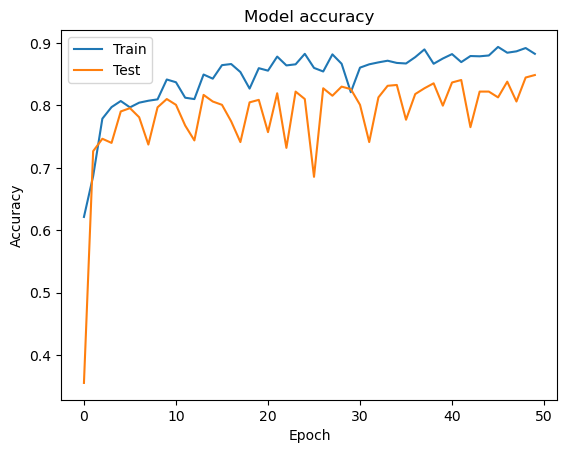

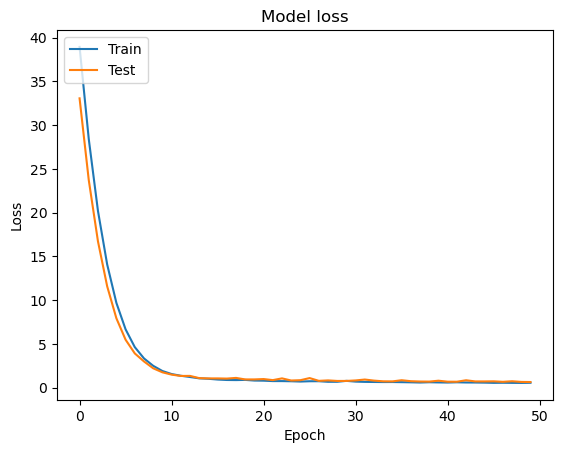

In [14]:
# Se grafican los resultados del accuracy del modelo

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()


# Se grafican las pérdidas del modelo

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('loss.png')
plt.show()

In [15]:
# Se aplica el modelo al conjunto test

predictions = model.predict(images_test)


# Se define un dataframe con la probabilidad de pertenecer a una clase, la imagen a la que refiere y el label original

resultados = pd.DataFrame({'pred':predictions.flatten(), 'image': df_test['Image'], 'label': df_test['Class'].values})

24/24 [==============================] - 2s 60ms/step


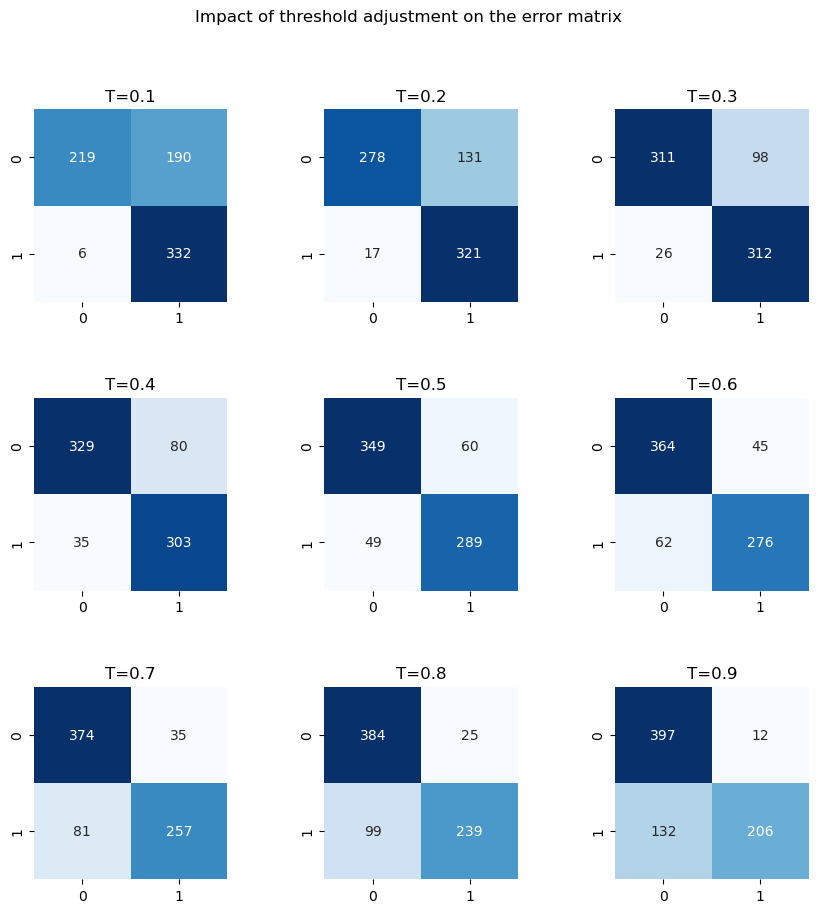

In [16]:
# Se grafican matrices de confusión para distintos valores del umbral de probabilidad a partir del cual una medida pertenece a clase 0 o 1

fig, axes = plt.subplots(3,3, figsize=(10,10))
for t, ax in enumerate(axes.flat):
    threshold = (t+1)/10
    y = resultados['label']
    y_pred_int = (np.where(resultados['pred']>threshold,1,0)).astype(int)
    c_matrix = metrics.confusion_matrix(y, y_pred_int)
    sns.heatmap(c_matrix, annot=True, cmap="Blues", fmt="d", ax=ax, cbar=False)
    ax.title.set_text("T=%.1f" % threshold)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("Impact of threshold adjustment on the error matrix")
plt.savefig('conf_matrix.png')

In [17]:
# Se muestran las métricas para los distintos umbrales

for i in range(1,10):
    threshold=i*0.1
    print('T =', round(threshold, 1))
    resultados['label_pred'] = np.where(resultados['pred']>threshold,1,0)
    TP = resultados[(resultados['label_pred']==1)&(resultados['label']==1)].value_counts().sum()
    TN = resultados[(resultados['label_pred']==0)&(resultados['label']==0)].value_counts().sum()
    FN = resultados[(resultados['label_pred']==0)&(resultados['label']==1)].value_counts().sum()
    FP = resultados[(resultados['label_pred']==1)&(resultados['label']==0)].value_counts().sum()
    accuracy = (FP+TN)/(TP+TN+FP+FN)
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    
    print('Proporción de Falsos Negativos frente a casos totales:', round(FN/len(resultados), 4), '%')
    print('Proporción de Falsos Positivos frente a casos totales:', round(FP/len(resultados), 4), '%')    
    print('accuracy =', round(accuracy, 4))
    print('recall =', round(recall, 4))
    print('precision =', round(precision, 4))
    print('')

T = 0.1
Proporción de Falsos Negativos frente a casos totales: 0.008 %
Proporción de Falsos Positivos frente a casos totales: 0.2544 %
accuracy = 0.5475
recall = 0.9822
precision = 0.636

T = 0.2
Proporción de Falsos Negativos frente a casos totales: 0.0228 %
Proporción de Falsos Positivos frente a casos totales: 0.1754 %
accuracy = 0.5475
recall = 0.9497
precision = 0.7102

T = 0.3
Proporción de Falsos Negativos frente a casos totales: 0.0348 %
Proporción de Falsos Positivos frente a casos totales: 0.1312 %
accuracy = 0.5475
recall = 0.9231
precision = 0.761

T = 0.4
Proporción de Falsos Negativos frente a casos totales: 0.0469 %
Proporción de Falsos Positivos frente a casos totales: 0.1071 %
accuracy = 0.5475
recall = 0.8964
precision = 0.7911

T = 0.5
Proporción de Falsos Negativos frente a casos totales: 0.0656 %
Proporción de Falsos Positivos frente a casos totales: 0.0803 %
accuracy = 0.5475
recall = 0.855
precision = 0.8281

T = 0.6
Proporción de Falsos Negativos frente a casos 

auc: 0.9313522663155914



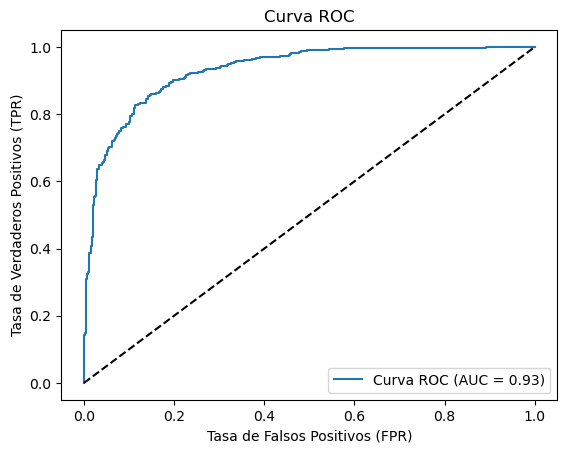

In [18]:
# Se define la columna del label predicho en función del umbral que se considere

T=0.4
resultados['label_pred'] = np.where(resultados['pred']>T,1,0)
auc = roc_auc_score(y_true = resultados['label'], y_score=resultados['pred'])
print('auc:', auc)
print('')


# Se grafica la curva ROC

fpr, tpr, thresholds = roc_curve(resultados['label'], resultados['pred'])

plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Línea base
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.savefig('roc.png')
plt.show()

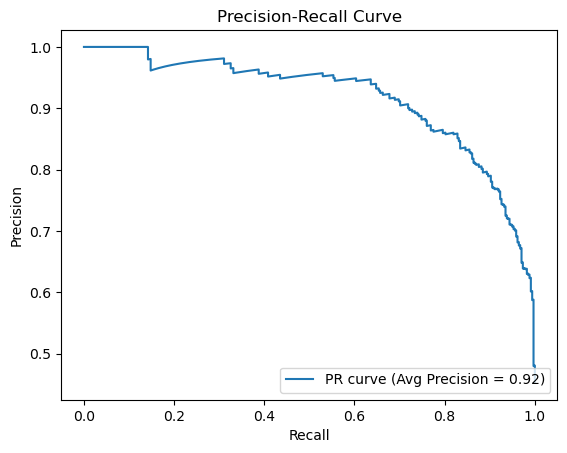

In [19]:
# Se grafica la curva precision-recall

precision, recall, thresholds = precision_recall_curve(resultados['label'], resultados['pred'])
average_precision = average_precision_score(resultados['label'], resultados['pred'])

plt.plot(recall, precision, label='PR curve (Avg Precision = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.savefig('prec_recall.png')
plt.show()

In [20]:
# Se define función que muestra en una imagen predicciones aleatorias con label real y predicho

def plot_predictions(num_examples=10):                  # num_examples debe ser múltiplo de 10.
    
    plt.figure(figsize=(12+int(num_examples/10),7+int(num_examples/10)))
    for i in range(1,int(num_examples)+1):    
        plt.subplot(int(num_examples/5),5,i)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        imagen_aleatoria = resultados.sample(n=1).iloc[0]['image']
        
        indice = data[data['Image']==imagen_aleatoria].index.item()
        path = data.paths[indice]
        img = image.load_img(path, target_size=(224, 224))
        
        label = resultados[resultados['image']==imagen_aleatoria]['label']
        label_pred = resultados[resultados['image']==imagen_aleatoria]['label_pred']
        
        
        plt.imshow(img)

        if int(label)==0:
            if int(label_pred)==0:
                plt.title('Tumor: No\n Tumor prediction: No')
            if int(label_pred)==1:
                plt.title('Tumor: No\n Tumor prediction: Yes')
        if int(label)==1:
            if int(label_pred)==0:
                plt.title('Tumor: Yes\n Tumor prediction: No')
            if int(label_pred)==1:
                plt.title('Tumor: Yes\n Tumor prediction: Yes')

        
        plt.suptitle(f"Predictions Examples",fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.savefig('examples'+str(num_examples)+'.png')
    plt.show()

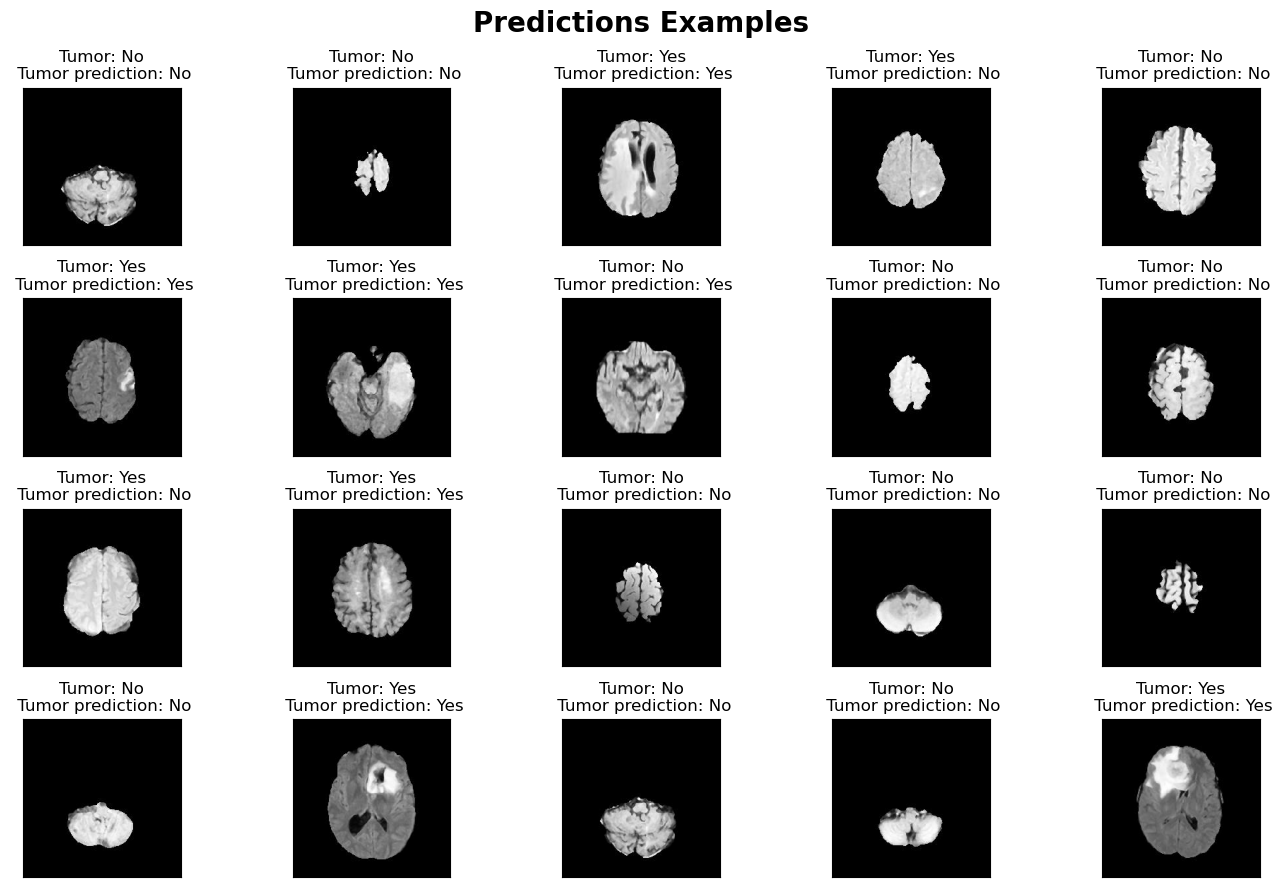

In [21]:
plot_predictions(num_examples=20)

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------------------------------------#

In [ ]:
# Aumentar el dataset rotando imágenes

In [ ]:
# Para que la siguiente celda se ejecute hay que ejecutar esta, reiniciar el kernel y volver a ejecutar todo.
# Puede que en un pc distinto no suceda.
pip install "numpy>=1.16.5,<1.23.0"

In [9]:
rotation_angle_1 = 30
#rotation_angle_2 = 180
input_dir = '/kaggle/working/_MODELLING/training'
output_dir = '/kaggle/working/_MODELLING/training'

# Leer y rotar cada imagen en el directorio de entrada
for filename in os.listdir(input_dir):
    warnings.filterwarnings('ignore')
    
    img_path = os.path.join(input_dir, filename)
    img = cv2.imread(img_path)
    
  
    indice = df_train[df_train['Image']==filename.replace('.jpg', '')].index.values.astype(int)[0]
    pixels = df_train['pixels'][indice]    
 

    # Rotación en un sentido
    M = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), rotation_angle_1, 1)
    rotated_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    new_filename = f'rotated_{rotation_angle_1}_cw_{filename}'    
    output_path = os.path.join(output_dir, new_filename)
    cv2.imwrite(output_path, rotated_img)
    new_row = {'Image': new_filename, 'Class': int(df_train['Class'][indice]), 'paths': output_path, 'pixels': pixels}
    df_train = df_train.append(new_row, ignore_index=True)
    
    # Rotación en el sentido contrario
    M = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), -rotation_angle_1, 1)
    rotated_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    new_filename = f'rotated_{rotation_angle_1}_ccw_{filename}'
    output_path = os.path.join(output_dir, new_filename)
    cv2.imwrite(output_path, rotated_img)
    new_row = {'Image': new_filename, 'Class': int(df_train['Class'][indice]), 'paths': output_path, 'pixels': pixels}
    df_train = df_train.append(new_row, ignore_index=True)
    
    
    # La rotación de 180º no se añade puesto que arroja peores resultados, pero se deja en comentario por si se quiere aplicar
    
    # Rotación sobre eje horizontal
    #M = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), rotation_angle_2, 1)
    #rotated_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    #new_filename = f'rotated_{rotation_angle_2}_cw_{filename}'    
    #output_path = os.path.join(output_dir, new_filename)
    #cv2.imwrite(output_path, rotated_img)
    #new_row = {'Image': new_filename, 'Class': int(df_train['Class'][indice]), 'paths': output_path, 'pixels': pixels}
    #df_train = df_train.append(new_row, ignore_index=True)

In [10]:
# Defino el modelo

model2 = Sequential()

model2.add(Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal", input_shape=(224, 224, 3)))
model2.add(Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l1(0.01)))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model2.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l1(0.01)))
model2.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l1(0.01)))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model2.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l1(0.01)))
model2.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l1(0.01)))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model2.add(Flatten())

model2.add(Dense(256, activation="relu"))   
model2.add(Dense(128, activation="relu"))
model2.add(Dense(1, activation="sigmoid"))

In [11]:
# Defino el nuevo conjunto de imágenes con imágenes rotadas

images_train_2 = np.stack(df_train["pixels"].values)       


# Defino los parámetros, compilo el modelo con optimizador y fiteo el conjunto train

batch_size = 256 
num_epochs = 100  # Número de épocas

import time

start_time = time.time()


model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.9999, epsilon=1e-10),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)


history2 = model2.fit(x=images_train_2,
          y=df_train['Class'],
          batch_size=batch_size,
          epochs=num_epochs,
          validation_split=0.25)#,
          #callbacks=[es])

print('Training complete')


end_time = time.time()
execution_time = (end_time - start_time)/60.0
print(f"Tiempo de ejecución: {execution_time:.2f} minutos")

Epoch 1/100
27/27 [==============================] - 47s 2s/step - loss: 35.9577 - accuracy: 0.6452 - val_loss: 27.8866 - val_accuracy: 0.7887
Epoch 2/100
27/27 [==============================] - 42s 2s/step - loss: 22.4022 - accuracy: 0.7667 - val_loss: 17.1175 - val_accuracy: 0.7852
Epoch 3/100
27/27 [==============================] - 41s 2s/step - loss: 13.5529 - accuracy: 0.7899 - val_loss: 10.1288 - val_accuracy: 0.8187
Epoch 4/100
27/27 [==============================] - 42s 2s/step - loss: 7.9205 - accuracy: 0.8100 - val_loss: 5.8669 - val_accuracy: 0.8248
Epoch 5/100
27/27 [==============================] - 42s 2s/step - loss: 4.6658 - accuracy: 0.8025 - val_loss: 3.5625 - val_accuracy: 0.8222
Epoch 6/100
27/27 [==============================] - 41s 2s/step - loss: 2.8797 - accuracy: 0.8207 - val_loss: 2.2392 - val_accuracy: 0.8275
Epoch 7/100
27/27 [==============================] - 42s 2s/step - loss: 1.8913 - accuracy: 0.8258 - val_loss: 1.6180 - val_accuracy: 0.7984
Epoch 8

In [ ]:
# Los siguientes pasos son idénticos al modelo anterior

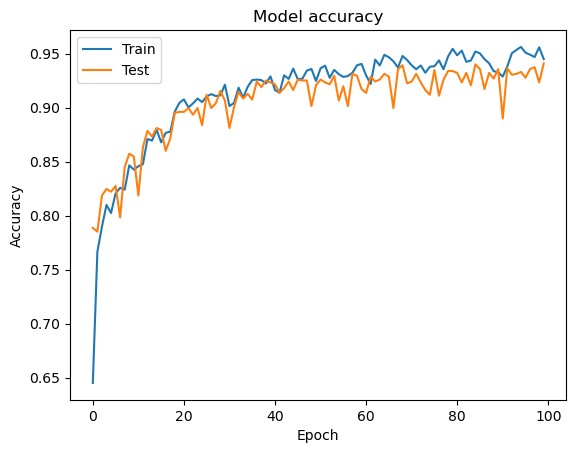

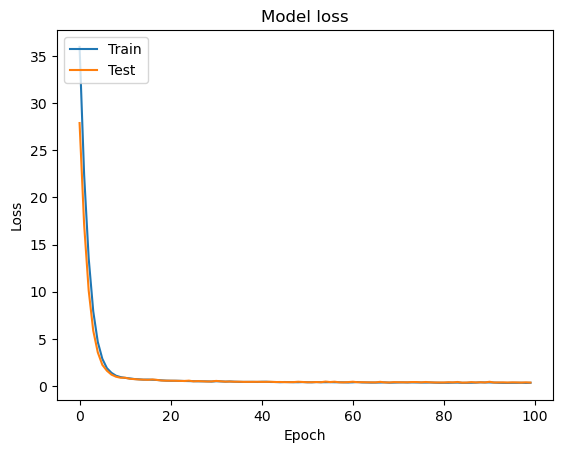

In [12]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()


plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('loss.png')
plt.show()

In [13]:
predictions2 = model2.predict(images_test)

resultados2 = pd.DataFrame({'pred':predictions2.flatten(), 'image': df_test['Image'], 'label': df_test['Class'].values})

23/23 [==============================] - 1s 46ms/step


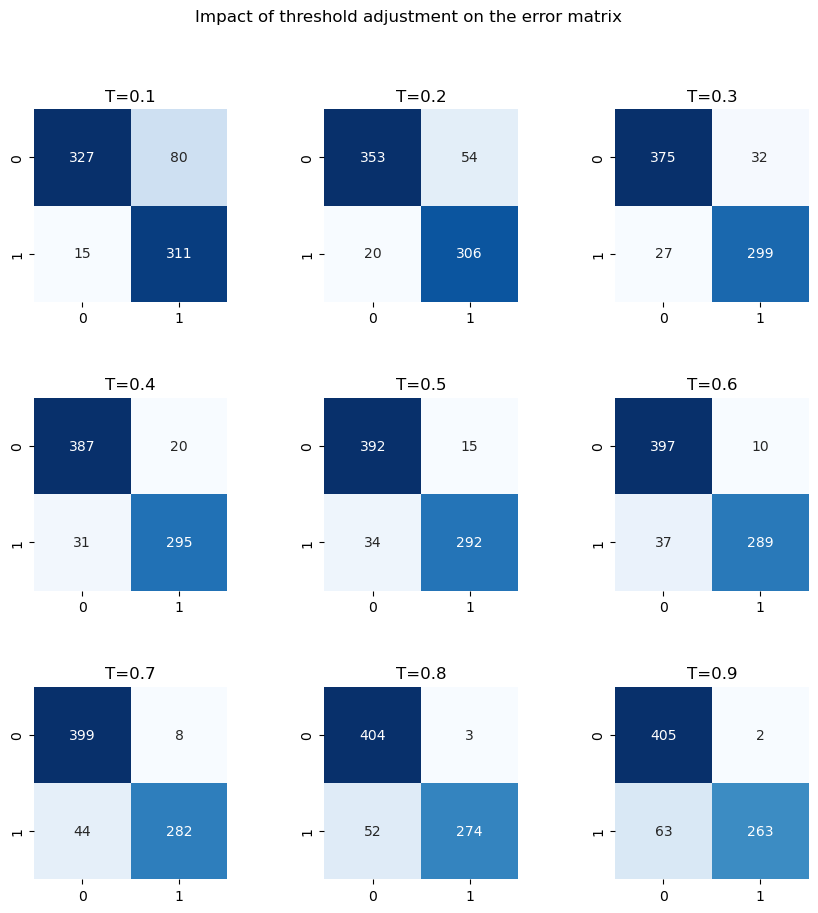

In [14]:
fig, axes = plt.subplots(3,3, figsize=(10,10))
for t, ax in enumerate(axes.flat):
    threshold = (t+1)/10
    y = resultados2['label']
    y_pred_int = (np.where(resultados2['pred']>threshold,1,0)).astype(int)
    c_matrix = metrics.confusion_matrix(y, y_pred_int)
    sns.heatmap(c_matrix, annot=True, cmap="Blues", fmt="d", ax=ax, cbar=False)
    ax.title.set_text("T=%.1f" % threshold)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("Impact of threshold adjustment on the error matrix")
plt.savefig('conf_matrix.png')


In [15]:
for i in range(1,10):
    threshold=i*0.1
    print('T =', round(threshold, 1))
    resultados2['label_pred'] = np.where(resultados2['pred']>threshold,1,0)
    TP = resultados2[(resultados2['label_pred']==1)&(resultados2['label']==1)].value_counts().sum()
    TN = resultados2[(resultados2['label_pred']==0)&(resultados2['label']==0)].value_counts().sum()
    FN = resultados2[(resultados2['label_pred']==0)&(resultados2['label']==1)].value_counts().sum()
    FP = resultados2[(resultados2['label_pred']==1)&(resultados2['label']==0)].value_counts().sum()
    
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    f1score = 2*TP/(2*TP+FP+FN)
    total = TP+TN+FP+FN
    
    print('')
    print('Proporción de Falsos Negativos frente a casos totales:', round(FN/total, 4), '%')
    print('Proporción de Falsos Positivos frente a casos totales:', round(FP/total, 4), '%')
    print('')
    print('Recall =', round(recall, 4))
    print('Precision =', round(precision, 4))
    print('Accuracy =', round(accuracy, 4))
    print('F1-score =', round(f1score, 4))
    print('')
    print('')

T = 0.1

Proporción de Falsos Negativos frente a casos totales: 0.0205 %
Proporción de Falsos Positivos frente a casos totales: 0.1091 %

Recall = 0.954
Precision = 0.7954
Accuracy = 0.8704
F1-score = 0.8675


T = 0.2

Proporción de Falsos Negativos frente a casos totales: 0.0273 %
Proporción de Falsos Positivos frente a casos totales: 0.0737 %

Recall = 0.9387
Precision = 0.85
Accuracy = 0.899
F1-score = 0.8921


T = 0.3

Proporción de Falsos Negativos frente a casos totales: 0.0368 %
Proporción de Falsos Positivos frente a casos totales: 0.0437 %

Recall = 0.9172
Precision = 0.9033
Accuracy = 0.9195
F1-score = 0.9102


T = 0.4

Proporción de Falsos Negativos frente a casos totales: 0.0423 %
Proporción de Falsos Positivos frente a casos totales: 0.0273 %

Recall = 0.9049
Precision = 0.9365
Accuracy = 0.9304
F1-score = 0.9204


T = 0.5

Proporción de Falsos Negativos frente a casos totales: 0.0464 %
Proporción de Falsos Positivos frente a casos totales: 0.0205 %

Recall = 0.8957
Precis

auc: 0.9756334694985002



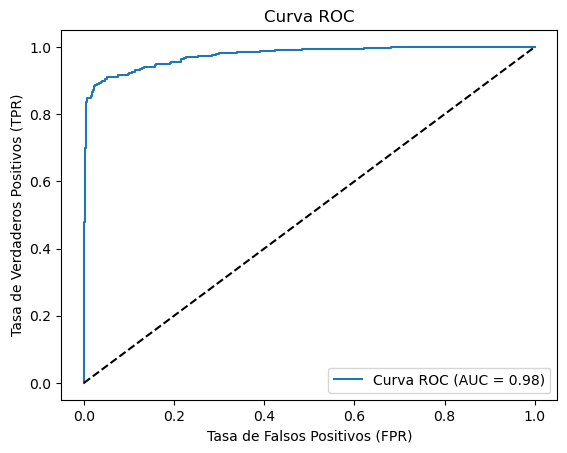

In [16]:
resultados2['label_pred'] = np.where(resultados2['pred']>0.4,1,0)
auc = roc_auc_score(y_true = resultados2['label'], y_score=resultados2['pred'])
print('auc:', auc)
print('')

fpr, tpr, thresholds = roc_curve(resultados2['label'], resultados2['pred'])


plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Línea base
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.savefig('roc.png')
plt.show()

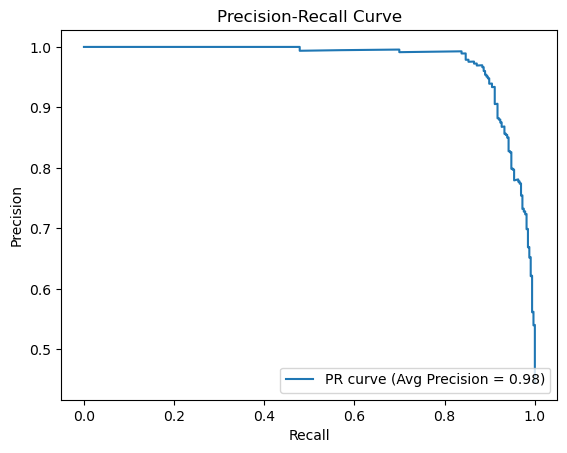

In [17]:
precision, recall, thresholds = precision_recall_curve(resultados2['label'], resultados2['pred'])
average_precision = average_precision_score(resultados2['label'], resultados2['pred'])

plt.plot(recall, precision, label='PR curve (Avg Precision = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.savefig('prec_recall.png')
plt.show()